## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

#%matplotlib qt
%matplotlib inline

In [2]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

def get_camera_calibration_parameters(globdir='./camera_cal/calibration*.jpg'):
     

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(globdir)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    assert len(objpoints) == len(imgpoints) # Check if same number of object and image point found

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist

def get_warp_parameters():
    ## TODO: Other solution for img.shape!
    img = mpimg.imread('./test_images/straight_lines2.jpg')
    src = np.float32(
        [(img.shape[1]/2-60, 450),
         (img.shape[1]/2+60, 450),
         (img.shape[1]-150, img.shape[0]-40),
         (150, img.shape[0]-40)])

    dst = np.float32(
        [(450, 200),
         (img.shape[1]-450, 200),
         (img.shape[1]-450, img.shape[0]),
         (450, img.shape[0])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

ret, mtx, dist = get_camera_calibration_parameters()
M, Minv = get_warp_parameters()
ym_per_pix = 12/202 # meters per pixel in y dimension
xm_per_pix = 3.7/300 # meters per pixel in x dimension

In [3]:
def print_example_images(img, img_aug):
    plt.figure(figsize=(17,5))
    plt.subplot(121), plt.xticks([]), plt.yticks([])
    if img.ndim == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
        
    plt.subplot(122), plt.xticks([]), plt.yticks([])
    if img_aug.ndim == 3:
        plt.imshow(img_aug)
    else:
        plt.imshow(img_aug, cmap='gray')
        
    plt.show()

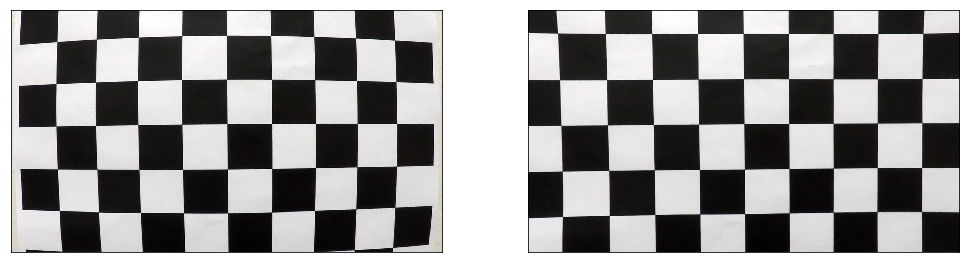

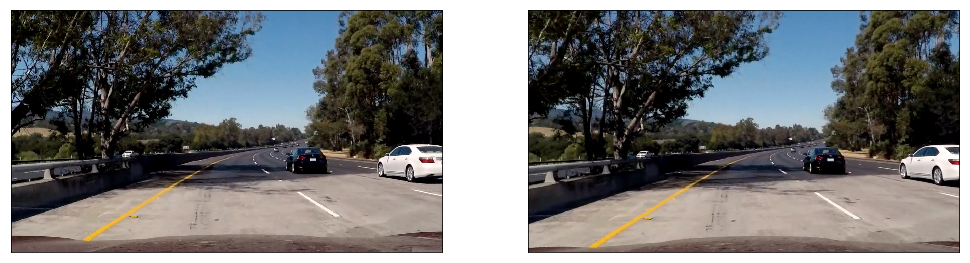

In [4]:
#1. pipeline step: Undistort image

def undistort_img(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


## undistortion demo
img = mpimg.imread('./camera_cal/calibration1.jpg')
dst = undistort_img(img, mtx, dist)
print_example_images(img, dst)

img = mpimg.imread('./test_images/test5.jpg')
dst = undistort_img(img, mtx, dist)
print_example_images(img, dst)

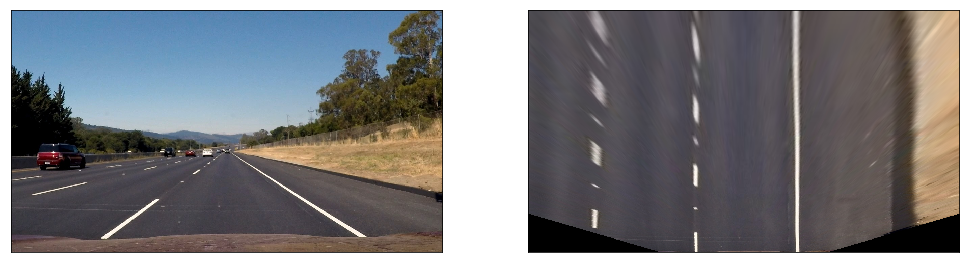

In [5]:
def birdview_warp(img, M=M):
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)


## Image warping demo
img = mpimg.imread('./test_images/straight_lines2.jpg')
warped = birdview_warp(img)
print_example_images(img, warped)

mpimg.imsave( "./output_images/warped2.jpg", warped)

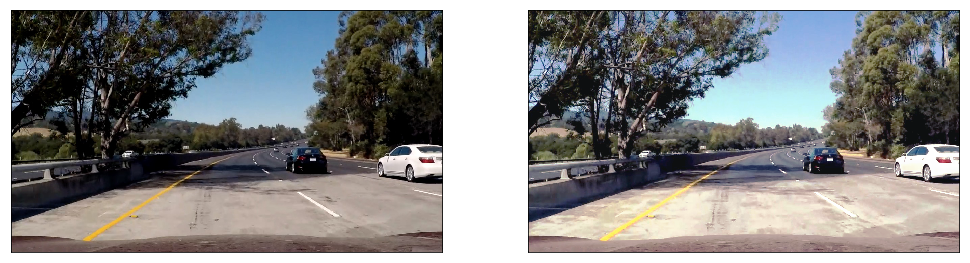

103.887117332
78.1254195602


In [6]:
def histogram_equ(img):
    from skimage import exposure
    img_hist = img.copy()
    
    #p2, p98 = np.percentile(img[:,:,0], (5, 95))
    #img_hist[:,:,0:] = exposure.rescale_intensity(img[:,:,0:], in_range=(p2, p98))
    #img_hist = np.clip(img_hist, 0, 255)
    
    for n in range(img.shape[2]):
        #img_hist[:,:,n] = cv2.equalizeHist(img[:,:,n])
        img_hist[:,:,n] = exposure.equalize_hist(img[:,:,n])*255
        #img_hist[:,:,n] = exposure.equalize_adapthist(img[:,:,n], clip_limit=0.03, nbins=256)*256
        #img_hist[:,:,n] = exposure.adjust_log(img[:,:,n], gain=1.5, inv=True)#*255
       #img_hist[:,:,n] = exposure.adjust_gamma(img[:,:,n], gamma=0.5)#*255
    return img_hist


## Demo
img = mpimg.imread('./test_images/test5.jpg')
hist = histogram_equ(img)
print_example_images(img, hist)
print(np.mean(img[360:,:,:]))
print(np.mean(warped[360:,:,:]))

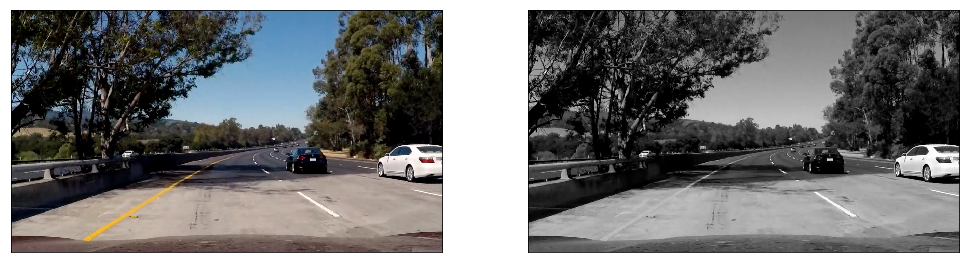

In [7]:
def get_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).copy()
    return gray


#demo
img = mpimg.imread('./test_images/test5.jpg')
gray = get_grayscale(img)
print_example_images(img, gray)

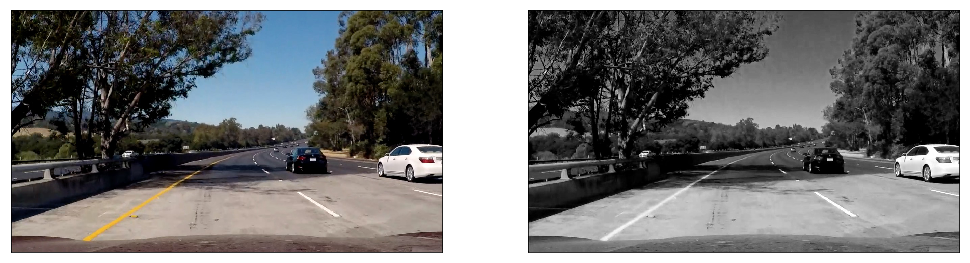

In [8]:
def get_redchannel(img):
    red = img[:,:,0].copy() ## use red channel
    return red


#demo
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
print_example_images(img, red)

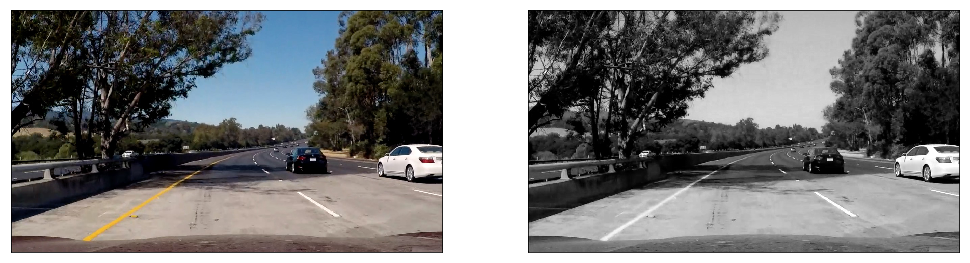

In [9]:
def get_s_chan(img):
    s = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2].copy() ## use red channel
    return s


#demo
img = mpimg.imread('./test_images/test5.jpg')
s = get_s_chan(img)
print_example_images(img, s)

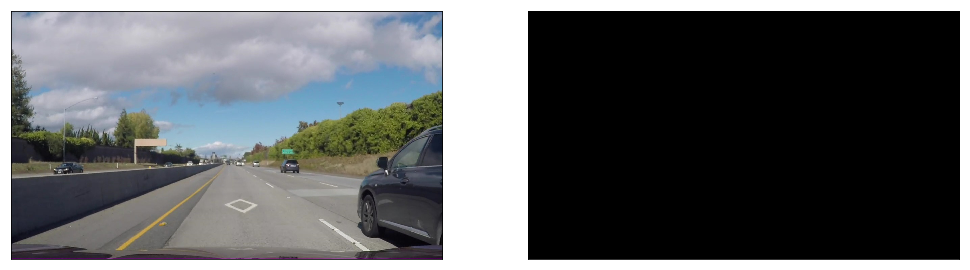

In [10]:
def apply_threshold_s_chan(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).copy()
    yellow_hsv_low  = np.array([ 0, 80, 200])
    yellow_hsv_high = np.array([ 40, 255, 255])
    
    binary_output = np.zeros_like(hsv[:,:,0])
    
    binary_output[(hsv[:,:,0]>yellow_hsv_low[0]) & (hsv[:,:,0]<yellow_hsv_high[0]) &
                  (hsv[:,:,1]>yellow_hsv_low[1]) & (hsv[:,:,1]<yellow_hsv_high[1]) &
                  (hsv[:,:,2]>yellow_hsv_low[2]) & (hsv[:,:,2]<yellow_hsv_high[2])] = 1
    
    return binary_output


#demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
s = apply_threshold_s_chan(img)
print_example_images(img, s)

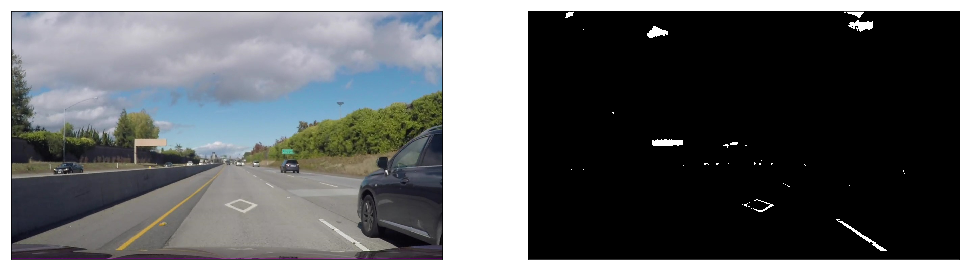

In [11]:
def apply_threshold(img, thresh=(0,255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output


##demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
red = get_redchannel(img)
thresh = apply_threshold(red, thresh=(200, 255))
print_example_images(img, thresh)

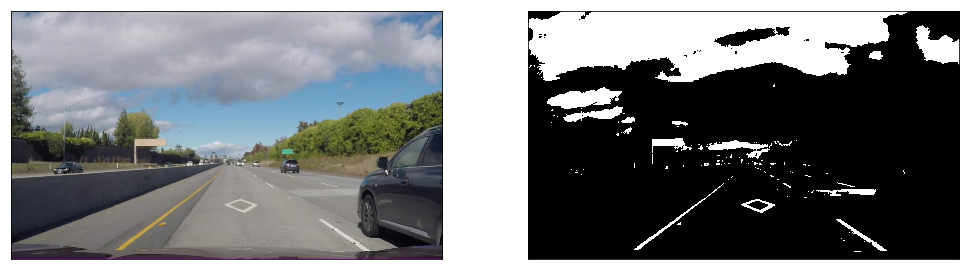

In [12]:
def apply_threshold_dynamic(img, percentile=0.03):
    binary_output = np.zeros_like(img)
    lower_thresh = 255
    while np.mean(binary_output[360:,:]) < (percentile):
        lower_thresh -= 5
        binary_output[(img >= lower_thresh)] = 1
    return binary_output


##demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic(red, percentile=0.03)
print_example_images(img, thresh)

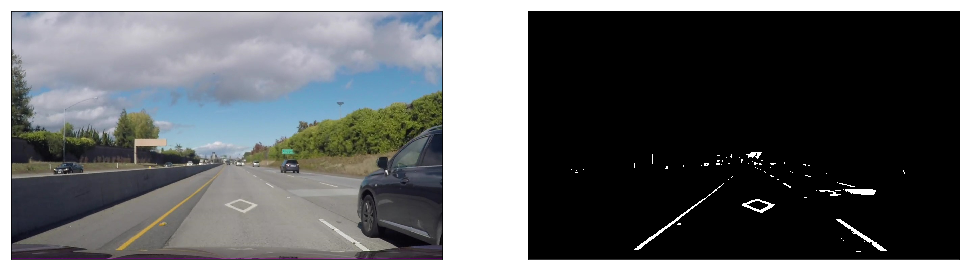

In [13]:
def apply_threshold_dynamic2(img, percentile=0.03):
    binary_output = np.zeros_like(img)
    percentile = 100 - (percentile*100)
    lower_thresh = np.percentile(img[360:,:], percentile)
    binary_output[(img >= lower_thresh)] = 1
    binary_output[:420,:] = 0
    return binary_output
 

##demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
print_example_images(img, thresh)

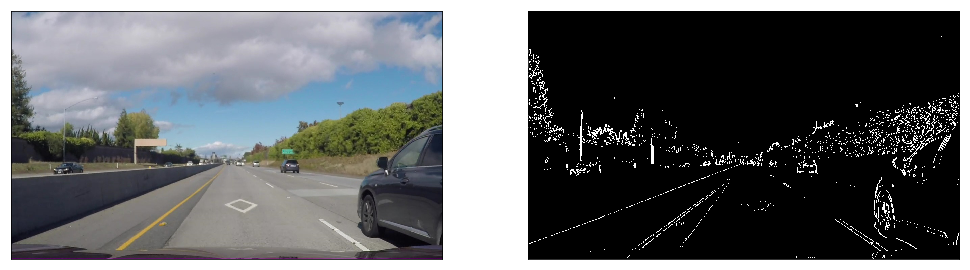

In [14]:
def apply_sobel_x_filter(img, thresh_abs_x = (0.01, 1)):
    
    # vertical contrast borders. Note that a Scharr kernel is used here for better performance 
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=-1)
    
    # calculate value (sharpness) of contrast border and apply threshold to it
    abs_sobelx = np.absolute(sobelx)

    # threshold values 
    scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
    binary_output_x = np.zeros_like(scaled_sobelx)
    binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
    
    return binary_output_x

# Demo
img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h33m05s984.jpg')
red = get_redchannel(img)
sobelx = apply_sobel_x_filter(red, thresh_abs_x = (0.1, 1))
print_example_images(img, sobelx)

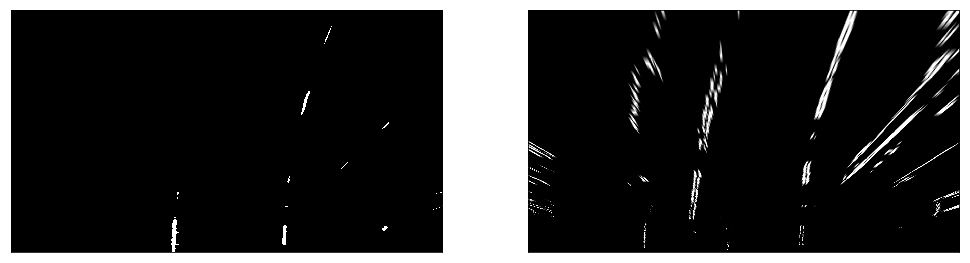

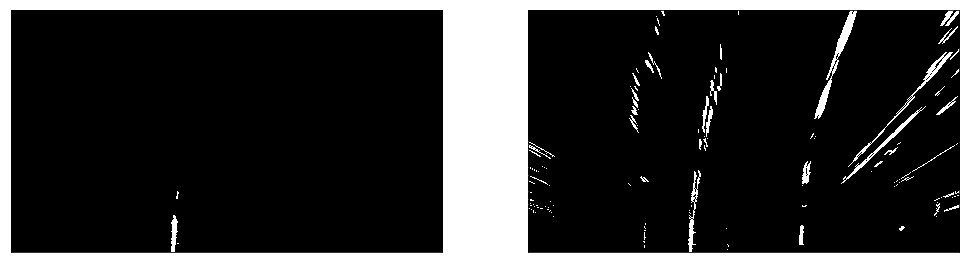

In [15]:
# combination test
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort_img(img, mtx, dist)
# 1. red channel with color thresholding
red_chan = get_redchannel(undist)
#thresh_red = apply_threshold_dynamic(red_chan, percentile=0.015)
thresh_red = apply_threshold_dynamic2(red_chan, percentile=0.03)

# 2. HSV with S channel and color thresholding    
s_chan = get_s_chan(undist)
thresh_s = apply_threshold_dynamic2(s_chan, percentile=0.03)

# 3. Sobel x with threshold (0.1,1)
sobelx = apply_sobel_x_filter(red_chan, thresh_abs_x = (0.1, 1))

yellow = apply_threshold_s_chan(img)


combined = np.zeros_like(thresh_red)
combined[(thresh_red == 1) | (thresh_s == 1) | (sobelx == 1)] = 1


birdview = birdview_warp(combined)

print_example_images(birdview_warp(thresh_red), birdview_warp(sobelx))
print_example_images(birdview_warp(yellow), birdview)

left:  513.807051621 in meters
right:  480.165032512 in meters
1 3


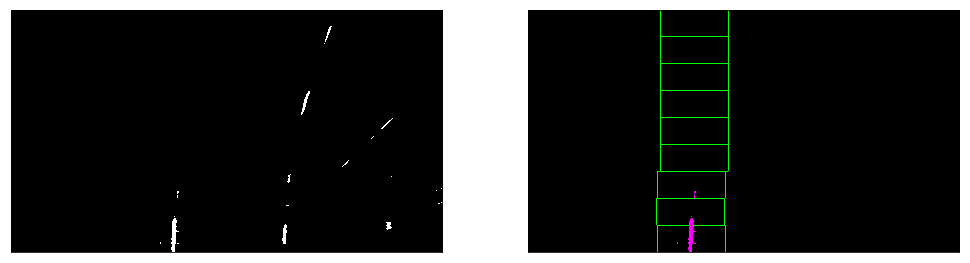

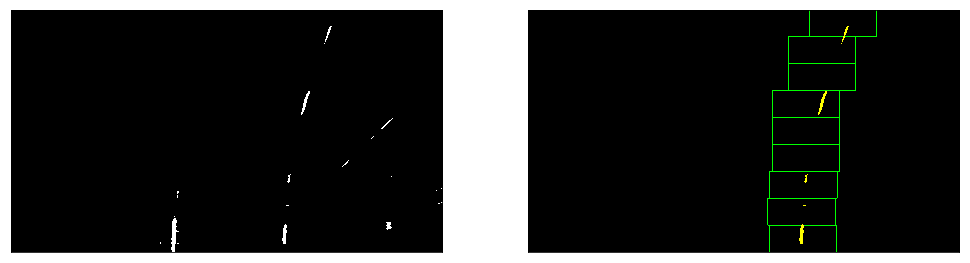

left:  513.807051621 in meters
right:  480.165032512 in meters
2 6


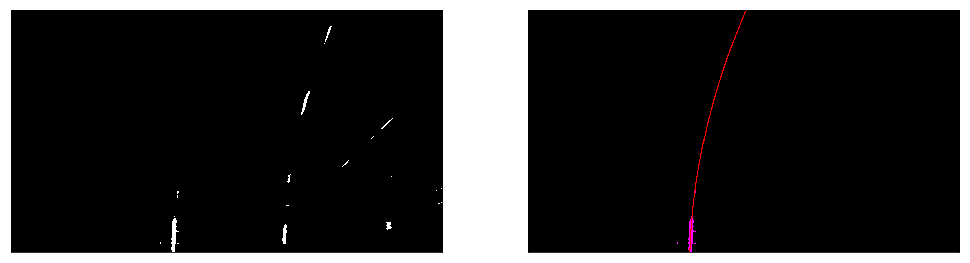

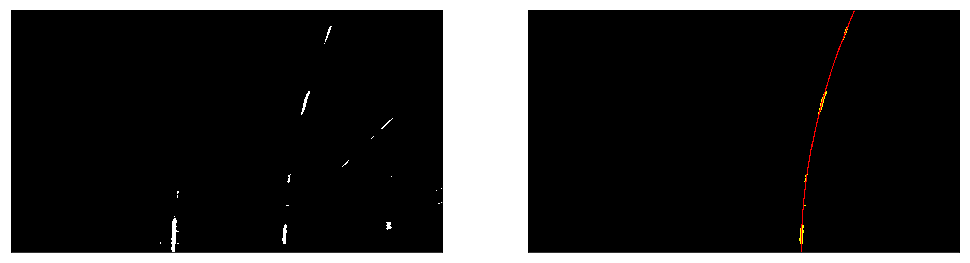

In [16]:
class Line():
    def __init__(self, lane_line = 'left'):
        
        self.lane_line = lane_line
        
        if self.lane_line == 'left':
            self.window_start = 350
            self.debug_color = [255, 0, 255]
        else: 
            self.window_start = 640
            self.debug_color = [255, 255, 0]
        
        self.nb_detected_lines = 0
        self.fit_last = []
        self.fit_pool = np.array([[],[]])
        self.fit_smooth = np.array([0.0, 0.0, 0.0])
        self.fit_valid = False
        
        self.fit_cr_pool = np.array([[],[]])
        self.curvature = 0
        
        self.debug_out = []
        
        
    def process_img(self, img):
        
        # Check if image is one channel to assure that no color images are passed
        assert img.ndim == 2
        
        # if there are no prior lines detected, start sliding window algorithm
        # otherwise do simple line finding
        if self.nb_detected_lines == 0:
            
            self.fit_pool = self.fit_pool[3:,:]
            self.fit_cr_pool = self.fit_cr_pool[25:,:]
            
            if self.fit_pool.size > 0:
                self.fit_smooth = np.mean(self.fit_pool, axis=0)            
            
            histogram = np.sum(img[360:,self.window_start:self.window_start+290], axis=0)
            peak = np.argmax(histogram) + self.window_start
            fit, fit_cr = self.find_line_sliding_window(img, peak)
        else:
            fit, fit_cr = self.find_line_simple(img, self.fit_smooth)

        if self.sanitycheck_parameters(fit, fit_cr):     
            self.update_parameters(fit, fit_cr)
        
        
    def sanitycheck_parameters(self, fit, fit_cr): 
        # if fit pool is empty just save new fit, since we can't do any sanity checks
        if self.fit_pool.size == 0:
            self.nb_detected_lines = 1
            self.fit_valid = True
            return True
        # check if new fit in between +-30% of the current line
        diff = np.abs(fit - self.fit_smooth)
        if np.all(diff < np.abs(self.fit_smooth)*0.3):
            if self.nb_detected_lines < 10:
                self.nb_detected_lines += 1
            self.fit_valid = True
            return True
        else:
            if self.nb_detected_lines > 0:
                self.nb_detected_lines -= 1
            self.fit_valid = False
            return False
        
        assert False
        
        

    def update_parameters(self, fit, fit_cr):
       
        self.fit_last = fit
        
        if self.fit_pool.size == 0:
            self.fit_pool = fit
            self.fit_pool = np.reshape(self.fit_pool, (1,3))
        else:
            self.fit_pool = np.vstack((self.fit_pool, fit))
            if self.fit_pool.shape[0] > 10:
                self.fit_pool = self.fit_pool[1:,:]
       
        self.fit_smooth = np.mean(self.fit_pool, axis=0)
        #self.fit_smooth[0] = np.mean(self.fit_pool[:,0])
        #self.fit_smooth[1] = np.mean(self.fit_pool[:,1])
        #self.fit_smooth[2] = np.mean(self.fit_pool[:,2])
        
        if self.fit_cr_pool.size == 0:
            self.fit_cr_pool = fit_cr
            self.fit_cr_pool = np.reshape(self.fit_cr_pool, (1,3))
        else:
            self.fit_cr_pool = np.vstack((self.fit_cr_pool, fit_cr))
            if self.fit_cr_pool.shape[0] > 25:
                self.fit_cr_pool = self.fit_cr_pool[1:,:]        
        
        # Lane curvature
        y_eval = img.shape[0]
        self.curvature = ((1 + (2*np.mean(self.fit_cr_pool[:,0])*y_eval*ym_per_pix 
                                + np.mean(self.fit_cr_pool[:,1]))**2)**1.5) / np.abs(2*np.mean(self.fit_cr_pool[:,0]))
        
      
    def find_line_sliding_window(self, img, peak):
        nwindows = 9
        window_height = np.int(img.shape[0]/nwindows)
        margin = 100
        adjust_window_pos = 50
        lane_coordx = np.array([])
        lane_coordy = np.array([])
    
        ## create debug output for sliding window 
        self.debug_out = np.zeros_like(img)
        self.debug_out = np.dstack((self.debug_out, self.debug_out, self.debug_out))
        
        for n in range(nwindows):
            window_lower_border = img.shape[0] - n*window_height
            window_slice = img[window_lower_border-window_height:window_lower_border, :]

            slice_window = window_slice[: , peak-margin:peak+margin]
            slice_line_coordy, slice_line_coordx = np.nonzero(slice_window)
            slice_line_coordy += window_lower_border - window_height
            slice_line_coordx += peak - 100
            
            lane_coordx = np.append(lane_coordx, slice_line_coordx)
            lane_coordy = np.append(lane_coordy, slice_line_coordy)
            
            # draw sliding window into debug output
            cv2.rectangle(self.debug_out,(peak-margin,window_lower_border-window_height),(peak+margin,window_lower_border),(0,255,0), 2)
            
            # recenter window if more than (adjust_window_pos) pixel are found
            if slice_line_coordx.size > adjust_window_pos:
                peak = np.int(np.mean(slice_line_coordx))

        assert lane_coordx.size == lane_coordy.size

        fit_cr = np.polyfit(lane_coordy*ym_per_pix, lane_coordx*xm_per_pix, 2)
        fit = np.polyfit(lane_coordy, lane_coordx, 2)
        
        # mark pixels that contributed to fit in debug output 
        self.debug_out[lane_coordy.astype(int), lane_coordx.astype(int)] = self.debug_color
        
        return fit, fit_cr 
    
    
    def find_line_simple(self, img, fit_old):
        margin = 50
        lane_coordx = np.array([])
        lane_coordy = np.array([])
        
        ## create debug output for sliding window 
        self.debug_out = np.zeros_like(img)
        self.debug_out = np.dstack((self.debug_out, self.debug_out, self.debug_out))
        
        px_line_coordy, px_line_coordx = np.nonzero(img)
        px_line_coord = np.transpose(np.asarray(np.nonzero(img)))
        test = fit_old[0]*(px_line_coord[:,0]**2) + fit_old[1]*px_line_coord[:,0] + fit_old [2]

        lane_coord = px_line_coord[((test+margin) > px_line_coord[:,1]) & ((test-margin) < px_line_coord[:,1])]
        
        lane_coordy = lane_coord[:,0]
        lane_coordx = lane_coord[:,1]
        
        fit_cr = np.polyfit(lane_coordy*ym_per_pix, lane_coordx*xm_per_pix, 2)
        fit = np.polyfit(lane_coordy, lane_coordx, 2)
        
        # mark pixels that contributed to fit in debug output 
        self.debug_out[lane_coordy.astype(int), lane_coordx.astype(int)] = self.debug_color
        
        ploty = np.linspace(0, 719, num=720)
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([fitx, ploty]))])
        # Draw the lane onto the warped blank image
        cv2.polylines(self.debug_out, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=2)
        

        return fit, fit_cr 
                
                
## TEST         
left = Line('left')
right = Line('right')

# first picture, sliding window algorithm should be used
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)
left.process_img(birdview)
right.process_img(birdview)
print('left: ', left.curvature, 'in meters')
print('right: ', right.curvature, 'in meters')

print(left.nb_detected_lines, left.fit_pool.size)
print_example_images(birdview, left.debug_out)
print_example_images(birdview, right.debug_out)


# second picture, simple line finding should be used
left.process_img(birdview)
right.process_img(birdview)
print('left: ', left.curvature, 'in meters')
print('right: ', right.curvature, 'in meters')

print(left.nb_detected_lines, left.fit_pool.size)
print_example_images(birdview, left.debug_out)
print_example_images(birdview, right.debug_out)


In [17]:
## Offset

def calculate_offset(left_fit, right_fit):
    y= 720
    xl = left_fit[0]* y**2 + left_fit[1]*y + left_fit[2]  
    xr = right_fit[0]* y**2 + right_fit[1]*y + right_fit[2]
    #print('left: ', xl)
    #print('right: ', xr)

    center_point = img.shape[1]/2
    offset_lane = (center_point - ((xr + xl)/2))*xm_per_pix
    return offset_lane


#Demo
offset_lane = calculate_offset(left.fit_smooth, right.fit_smooth)
print('Offset from middle of the lane: ', offset_lane*100, 'cm')

Offset from middle of the lane:  -5.53899849436 cm


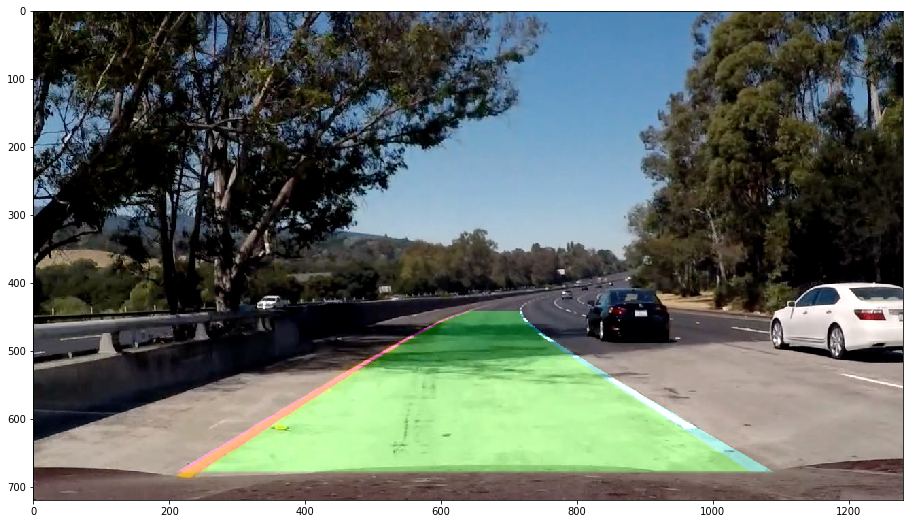

In [18]:
## Draw line

def draw_on_image(img, left_fit, right_fit):
    
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros(img.shape[0:2]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=12)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=12)
        
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result
    
    

## Demo
img = mpimg.imread('./test_images/test5.jpg')
result = draw_on_image(img, left.fit_smooth, right.fit_smooth)
plt.figure(figsize=(17,9))
plt.imshow(result)

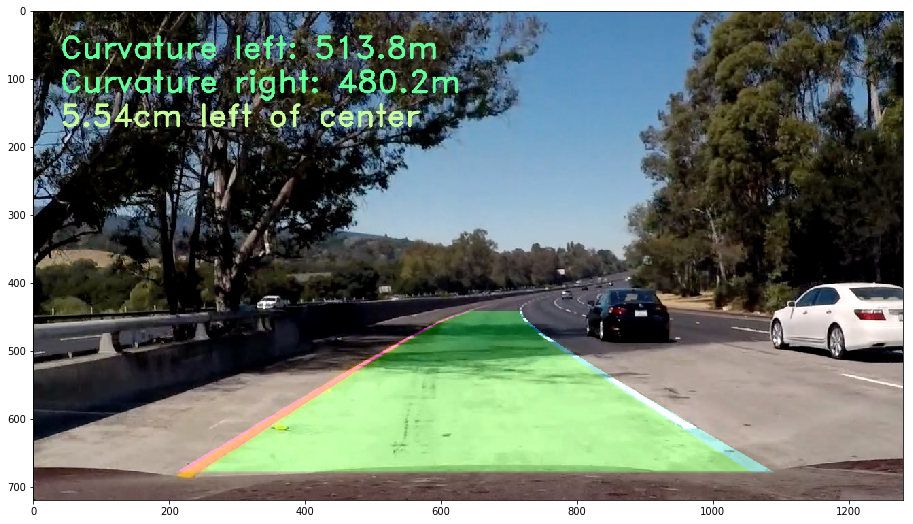

In [19]:
## Draw Text on image
def draw_text(img, left_curvature, right_curvature, offset):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curvature left: ' + '{:04.1f}'.format(left_curvature) + 'm'
    cv2.putText(img,text, (40,70), font, 1.5, (100,255,155), 2, cv2.LINE_AA)
    text = 'Curvature right: ' + '{:04.1f}'.format(right_curvature) + 'm'
    cv2.putText(img,text, (40,120), font, 1.5, (100,255,155), 2, cv2.LINE_AA)
        
    if offset > 0:
        offset_side = 'right'
    elif offset < 0:
        offset_side = 'left'
    offset = abs(offset)
    
    text = '{:02.2f}'.format(offset*100) + 'cm ' + offset_side + ' of center'
    cv2.putText(img,text, (40,170), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return img
    
##Demo
result = draw_text(result, left.curvature, right.curvature, offset_lane)
plt.figure(figsize=(17,9))
plt.imshow(result)

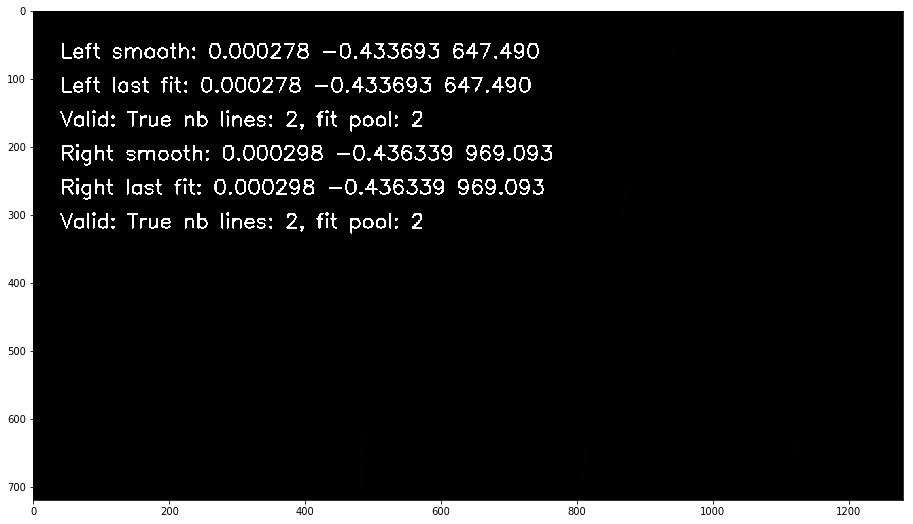

In [20]:
## Draw Debug Text on image 
def draw_debug_text(img):
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Left smooth: ' + str('{:.6f}'.format(left.fit_smooth[0])) + ' ' + str('{:.6f}'.format(left.fit_smooth[1])) + ' ' + str('{:.3f}'.format(left.fit_smooth[2]))
    cv2.putText(img,text, (40,70), font, 1, (255,255,155),2)
    text = 'Left last fit: ' + str('{:.6f}'.format(left.fit_last[0])) + ' ' + str('{:.6f}'.format(left.fit_last[1])) + ' ' + str('{:.3f}'.format(left.fit_last[2]))
    cv2.putText(img,text, (40,120), font, 1, (255,255,155),2)
    text = 'Valid: '+ str(left.fit_valid) + ' nb lines: ' + str(left.nb_detected_lines) + ', fit pool: ' + str(left.fit_pool.shape[0]) 
    cv2.putText(img,text, (40,170), font, 1, (255,255,155),2)
    
    
    
    
    text = 'Right smooth: ' + str('{:.6f}'.format(right.fit_smooth[0])) + ' ' + str('{:.6f}'.format(right.fit_smooth[1])) + ' ' + str('{:.3f}'.format(right.fit_smooth[2]))
    cv2.putText(img,text, (40,220), font, 1, (255,255,155),2)
    text = 'Right last fit: ' + str('{:.6f}'.format(right.fit_last[0])) + ' ' + str('{:.6f}'.format(right.fit_last[1])) + ' ' + str('{:.3f}'.format(right.fit_last[2]))
    cv2.putText(img,text, (40,270), font, 1, (255,255,155),2)
    text = 'Valid: '+ str(right.fit_valid) + ' nb lines: ' + str(right.nb_detected_lines) + ', fit pool: ' + str(right.fit_pool.shape[0]) 
    cv2.putText(img,text, (40,320), font, 1, (255,255,155),2)  
    
    return img
    
##Demo
result = draw_debug_text(birdview)
plt.figure(figsize=(17,9))
plt.imshow(result, cmap='gray')

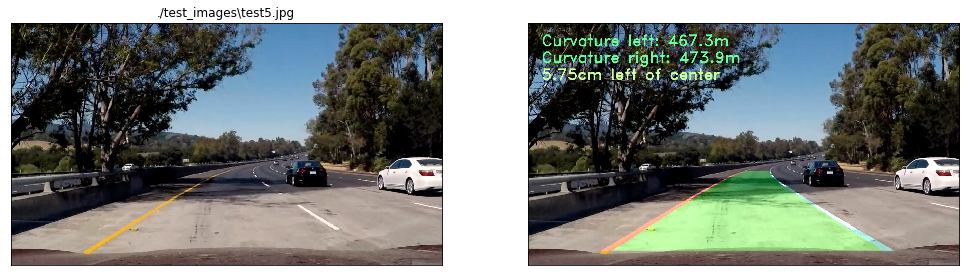

In [21]:
# define pipeline for lane detection
def pipeline_advanced_lane_finding(img, debug=False):
    
    undist = undistort_img(img, mtx, dist)
    # 1. red channel with color thresholding
    red_chan = get_redchannel(undist)
    #thresh_red = apply_threshold_dynamic(red_chan, percentile=0.015)
    thresh_red = apply_threshold_dynamic2(red_chan, percentile=0.03)
    
    # 2. HSV with S channel and color thresholding    
    #s_chan = get_s_chan(undist)
    #thresh_s = apply_threshold_dynamic2(s_chan, percentile=0.03)
    
    # 3. Sobel x with threshold (0.1,1)
    #sobelx = apply_sobel_x_filter(red_chan, thresh_abs_x = (0.1, 1))
    
    combined = np.zeros_like(thresh_red)
    combined[(thresh_red == 1)] = 1 #| (thresh_s == 1) | (sobelx == 1)] = 1
    
    
    birdview = birdview_warp(combined)
    
    left.process_img(birdview)
    right.process_img(birdview)
    
    offset_lane = calculate_offset(left.fit_smooth, right.fit_smooth)
    
    result = draw_on_image(img, left.fit_smooth, right.fit_smooth)
    result = draw_text(result, left.curvature, right.curvature, offset_lane)
    
    if debug == True:
        draw_debug_text(img)
        result = np.vstack((img, result))
        debug_out = debug_out = left.debug_out + right.debug_out
        birdview = np.dstack((birdview, birdview, birdview))*255
        
        debug_out = np.vstack((birdview, debug_out))
        
        result = np.hstack((result, debug_out))
    
    
    return result


#print all test images and how the pipeline works

images = glob.glob('./test_images/test5*')


for n, filename in enumerate(images):
    img = mpimg.imread(filename)
    plt.figure(figsize=(17,5))
    plt.subplot(1, 2, 1), plt.xticks([]), plt.yticks([])
    plt.title(filename)
    plt.imshow(img)
    left = Line('left')
    right = Line('right')
    dst = pipeline_advanced_lane_finding(img, debug=False)
    plt.subplot(1, 2, 2), plt.xticks([]), plt.yticks([])
    plt.imshow(dst, cmap='gray')



# Video

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return pipeline_advanced_lane_finding(image, debug=True)

In [24]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
left = Line('left')
right = Line('right')
clip1 = VideoFileClip("project_video.mp4").subclip(35,45)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████▊| 250/251 [00:50<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 53.9 s


# Challenge Video

In [ ]:
project_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
left = Line('left')
right = Line('right')
clip1 = VideoFileClip("challenge_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

# Harder Challenge Video

In [ ]:
project_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
left = Line('left')
right = Line('right')
clip1 = VideoFileClip("harder_challenge_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

# Backup
---

In [ ]:
def sobel_parameters(img, 
                     thresh_abs_x = (0.01, 1), 
                     thresh_abs_y = (0.01, 1), 
                     thresh_mag = (0.05, 1), 
                     thresh_dir = (0, 1)):
    
    # vertical contrast borders. Note that a Scharr kernel is used here for better performance 
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=-1)
    
    # horizontal contrast borders. Scharr kernel
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=-1)
    
    # diagonal contrast borders high->low. Scharr kernel
    kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 
    sobel10 = cv2.filter2D(img, -1, kernel10)
    
    # diagonal contrast borders low->high. Scharr kernel
    kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 
    sobel01 = cv2.filter2D(img, -1, kernel01)
     
    # calculate value (sharpness) of contrast border and apply threshold to it
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # threshold values 
    scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
    binary_output_x = np.zeros_like(scaled_sobelx)
    binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
    
    scaled_sobely = abs_sobely/np.max(abs_sobely)
    binary_output_y = np.zeros_like(scaled_sobely)
    binary_output_y[(scaled_sobely >= thresh_abs_y[0]) & (scaled_sobely <= thresh_abs_y[1])] = 1
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = mag/np.max(mag)
    binary_output_mag = np.zeros_like(scaled_mag)
    binary_output_mag[(scaled_mag >= thresh_mag[0]) & (scaled_mag <= thresh_mag[1])] = 1
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output_dir = np.zeros_like(dir_grad)
    binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
    
    # put all binary images into one big numpy array
    bin_out = img.copy()
    bin_out = np.dstack((bin_out, binary_output_x))
    bin_out = np.dstack((bin_out, binary_output_y))
    bin_out = np.dstack((bin_out, binary_output_mag))
    bin_out = np.dstack((bin_out, binary_output_dir))
    
    dir_mag = np.zeros_like(binary_output_dir)
    dir_mag[(bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    bin_out = np.dstack((bin_out, dir_mag))
    
    combined = np.zeros_like(binary_output_dir)
    combined[(bin_out[:,:,1] == 1) & (bin_out[:,:,2] == 1) & (bin_out[:,:,3] == 1) & (bin_out[:,:,4] == 1)] = 1
    bin_out = np.dstack((bin_out, combined))
    
    
    return bin_out

In [ ]:
img = mpimg.imread('./test_images/test5.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)

bin_out = sobel_parameters(img)
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1:4], cmap='gray')


plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,1], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,2], cmap='gray')
plt.figure(figsize=(17,10))
plt.imshow(bin_out[:,:,3], cmap='gray')

In [ ]:
from IPython.html.widgets import *


def sobel(thresh_abs_x_low = 0.1, thresh_abs_x_high = 1,
         thresh_abs_y_low = 0, thresh_abs_y_high = 1, 
         thresh_mag_low = 0, thresh_mag_high = 1,
         thresh_dir_low = 0, thresh_dir_high=0.67):
    
    
    img = mpimg.imread('./test_images/test1.jpg')
    gray = get_redchannel(img)
    birdview = birdview_warp(gray)
    bin_out = sobel_parameters(birdview, 
                               thresh_abs_x = (thresh_abs_x_low, thresh_abs_x_high), 
                                thresh_abs_y = (thresh_abs_y_low, thresh_abs_y_high), 
                                thresh_mag = (thresh_mag_low, thresh_mag_high), 
                                thresh_dir = (thresh_dir_low, thresh_dir_high))
    
    plt.figure(figsize=(17,10))
    #out = np.dstack((bin_out[:,:,1], bin_out[:,:,2], bin_out[:,:,5]))
    plt.imshow(bin_out[:,:,6], cmap='gray')
    plt.show()
    return

interact(sobel, thresh_abs_x_low = (0,1,0.01), thresh_abs_x_high = (0,1,0.01),
         thresh_abs_y_low = (0,1,0.01), thresh_abs_y_high = (0,1,0.01), 
         thresh_mag_low = (0,1,0.01), thresh_mag_high = (0,1,0.01),
         thresh_dir_low = (0,1.57,0.01), thresh_dir_high= (0,1.57,0.01))

In [ ]:
img = mpimg.imread('./test_images/test1.jpg')
print_example_images(img, birdview_warp(img))    

In [ ]:
## sobel demo
img = mpimg.imread('./test_images/circle.png')
plt.figure(figsize=(17,5))
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
print(sobelx.shape, sobelx.max(), sobelx.min())
placeholder = gray.copy()

# set parameters
thresh_abs_x = (150, 255)
thresh_abs_y = (150, 255)
thresh_mag = (150, 255)
thresh_dir = (0, 0.1)

# abs
abs_sobelx = np.absolute(sobelx)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx > thresh_abs_x[0]) & (scaled_sobelx < thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

abs_sobely = np.absolute(sobely)
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
binary_output_y = np.zeros_like(scaled_sobely)
binary_output_y[(scaled_sobely > thresh_abs_y[0]) & (scaled_sobely < thresh_abs_y[1])] = 1
placeholder = np.dstack((placeholder, binary_output_y))

# mag
mag = np.sqrt(sobelx**2 + sobely**2)
scaled_mag = np.uint8(255*mag/np.max(mag))
binary_output_mag = np.zeros_like(scaled_mag)
binary_output_mag[(scaled_mag > thresh_mag[0]) & (scaled_mag < thresh_mag[1])] = 1
placeholder = np.dstack((placeholder, binary_output_mag))

# direction
#thresh_dir = (thresh_dir*np.pi)-(np.pi/2)
dir_grad = np.arctan2(abs_sobely, abs_sobelx)
binary_output_dir = np.zeros_like(dir_grad)
binary_output_dir[(dir_grad > thresh_dir[0]) & (dir_grad <= thresh_dir[1])] = 1
placeholder = np.dstack((placeholder, binary_output_dir))


plt.figure(figsize=(17,5))
plt.imshow(gray, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_x, cmap='gray')


plt.figure(figsize=(17,5))
plt.imshow(binary_output_y, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_mag, cmap='gray')

plt.figure(figsize=(17,5))
plt.imshow(binary_output_dir, cmap='gray')

print(placeholder.shape)

In [ ]:
abs_sobelx = np.absolute(sobelx)
print(abs_sobelx.min(), abs_sobelx.max())
scaled_sobelx = abs_sobelx/np.max(abs_sobelx)
print(scaled_sobelx.min(), scaled_sobelx.max())
binary_output_x = np.zeros_like(scaled_sobelx)
binary_output_x[(scaled_sobelx >= thresh_abs_x[0]) & (scaled_sobelx <= thresh_abs_x[1])] = 1
placeholder = np.dstack((placeholder, binary_output_x))

In [ ]:
# color space demo
from skimage import exposure

img = mpimg.imread('./test_images/vlcsnap-2017-08-02-08h34m19s558.jpg')
plt.figure(figsize=(17,5))
plt.imshow(img)
img = hist_equ(img)

plt.figure(figsize=(17,5))
plt.imshow(img)

img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#img_hsv= img

plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,0], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,1], cmap='gray')
plt.figure(figsize=(17,5))
plt.imshow(img_hsv[:,:,2], cmap='gray')

In [ ]:
# lane curvature
y_eval = 720



left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])
print(left_curverad, right_curverad, 'in meters')

In [ ]:
# test with custom sobel kernel
img = mpimg.imread('./test_images/circle.png')

kernel10 = np.array([[0, -3, -10],[3, 0, -3],[10, 3, 0]]) 

kernel01 = np.array([[10, 3, 0],[3, 0, -3],[0, -3, -10]]) 

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

sobel_custom1 = cv2.filter2D(gray, -1, kernel10)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom1, cmap='gray')

sobel_custom2 = cv2.filter2D(gray, -1, kernel01)
plt.figure(figsize=(17,10))
plt.imshow(sobel_custom2, cmap='gray')

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobelx, cmap='gray')

sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
plt.figure(figsize=(17,10))
plt.imshow(sobely, cmap='gray')

In [ ]:
x = np.array(range(0,3))

for n in range(6,15):
    print(x.size)
    x = np.append(x, n)
    if x.size > 5:
        x = x[1:]
    print(x)



In [ ]:
x = [0,1,2]

for n in range(6,15):
    print(len(x))
    x.append(n)
    if len(x) > 5:
        x = x[1:]
    print(x)



In [ ]:
a = np.array([[50, 48, 4, 3, 2, 1, 1]])

In [ ]:
print(np.median(a), np.mean(a))

In [ ]:
a = np.array([])
a.ndim

In [ ]:
left_fit.ndim

In [ ]:
class _alt_Lines():
    def __init__(self):
        
        self.last_detected_lines = 0
        
        self.left_fit_pool = np.array([])
        self.curvature_left = 0
           
        self.right_fit_pool = []
        self.curvature_left = 0
        
        self.offset_lane = 0
        
    def process_img(self, img):
        if self.last_detected_lines == 0:
            left_fit, right_fit, left_fit_cr, right_fit_cr = find_lines(img)
            print(left_fit, right_fit, left_fit_cr, right_fit_cr)
        else:
            #TODO - simple line finding here
            print('bla')
        
        if self.sanitycheck_parameters(left_fit, right_fit, left_fit_cr, right_fit_cr):     
            self.update_parameters(left_fit, right_fit, left_fit_cr, right_fit_cr)
        
        
    def sanitycheck_parameters(self, left_fit, right_fit, left_fit_cr, right_fit_cr): 
        #TODO
        if 1 == 1:
            self.last_detected_lines += 1
            return True
        else:
            return False

    def update_parameters(self, left_fit, right_fit, left_fit_cr, right_fit_cr):
        
        
        if self.left_fit_pool.size == 0:
            self.left_fit_pool = left_fit
        else:
            self.left_fit_pool = np.vstack((self.left_fit_pool, left_fit))
            if self.left_fit_pool.shape[1] > 10:
                self.left_fit_pool = self.left_fit_pool[1:,:]
        print(np.median(left_fit_pool[:,0]))
        print(np.median(left_fit_pool[:,1]))
        print(np.median(left_fit_pool[:,2]))
         
        
        # Lane curvature  ##TODO: this has to be smoothed out as well. (np.median(self.left_fit_pool))
        y_eval = img.shape[0]
        self.curvature_left = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.abs(2*left_fit_cr[0])
        self.curvature_right = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.abs(2*right_fit_cr[0])
        print(self.curvature_left, self.curvature_right, 'in meters')
        
        ## Offset
        y= img.shape[0]
        xl = left_fit[0]* y**2 + left_fit[1]*y + left_fit[2]  
        xr = right_fit[0]* y**2 + right_fit[1]*y + right_fit[2]
        print('left: ', xl)
        print('right: ', xr)
        center_point = img.shape[1]/2
        self.offset_lane = (center_point - ((xr + xl)/2))*xm_per_pix
        print('Offset from middle of the lane: ', self.offset_lane*100, 'cm')

        
## TEST         
lines = Lines()
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)
lines.process_img(birdview)

In [ ]:
def find_lines(img):

    assert img.ndim == 2
    
    histogram = np.sum(img[360:,350:930], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    left_peak = np.argmax(histogram[:midpoint]) + 350
    right_peak = np.argmax(histogram[midpoint:]) + midpoint + 350
    print('left_peak: ', left_peak)
    print('right_peak: ', right_peak)
    
    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)
    #left_peak = 500
    #right_peak = 800
    margin = 100
    adjust_window_pos = 50
    left_lane_coordx = np.array([])
    left_lane_coordy = np.array([])
    right_lane_coordx = np.array([])
    right_lane_coordy = np.array([])

    for n in range(nwindows):
        window_lower_border = img.shape[0] - n*window_height
        window_slice = img[window_lower_border-window_height:window_lower_border, :]

        slice_left_window = window_slice[: , left_peak-margin:left_peak+margin]
        slice_left_line_coordy, slice_left_line_coordx = np.nonzero(slice_left_window)
        slice_left_line_coordy += window_lower_border - window_height
        slice_left_line_coordx += left_peak - 100

        left_lane_coordx = np.append(left_lane_coordx, slice_left_line_coordx)
        left_lane_coordy = np.append(left_lane_coordy, slice_left_line_coordy)

        if slice_left_line_coordx.size > adjust_window_pos:
            left_peak = np.int(np.mean(slice_left_line_coordx))


        slice_right_window = window_slice[: , right_peak-margin:right_peak+margin]
        slice_right_line_coordy, slice_right_line_coordx = np.nonzero(slice_right_window)
        slice_right_line_coordy += window_lower_border - window_height
        slice_right_line_coordx += right_peak - 100

        right_lane_coordx = np.append(right_lane_coordx, slice_right_line_coordx)
        right_lane_coordy = np.append(right_lane_coordy, slice_right_line_coordy)

        if slice_right_line_coordx.size > adjust_window_pos:
            right_peak = np.int(np.mean(slice_right_line_coordx))


    assert left_lane_coordx.size == left_lane_coordy.size
    assert right_lane_coordx.size == right_lane_coordy.size

    left_fit_cr = np.polyfit(left_lane_coordy*ym_per_pix, left_lane_coordx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_lane_coordy*ym_per_pix, right_lane_coordx*xm_per_pix, 2)    
    
    left_fit = np.polyfit(left_lane_coordy, left_lane_coordx, 2)
    right_fit = np.polyfit(right_lane_coordy, right_lane_coordx, 2)    
    

    return left_fit, right_fit, left_fit_cr, right_fit_cr





    
img = mpimg.imread('./test_images/test5.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)
left_fit, right_fit, left_fit_cr, right_fit_cr = find_lines(birdview)
print(left_fit, right_fit)

In [ ]:
def findlines(img):
    
    histogram = np.sum(img[int(img.shape[0]/2):,400:880], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base + 400
    rightx_current = rightx_base + 400
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    print(nonzeroy[left_lane_inds])
    
    
    plt.figure(figsize=(17,5))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    return left_fit, right_fit, leftx, lefty, rightx, righty




        
## Demo
img = mpimg.imread('./test_images/test4.jpg')
red = get_redchannel(img)
thresh = apply_threshold_dynamic2(red, percentile=0.03)
birdview = birdview_warp(thresh)
left_fit, right_fit, leftx, lefty, rightx, righty = findlines(birdview)
print_example_images(img, thresh)

print(leftx)
print(lefty)

# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.figure(figsize=(17,5))
plt.imshow(birdview_warp(img), cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()


In [ ]:
left_fit

In [ ]:
test = np.vstack((left_fit, left_fit))

In [ ]:
test

In [ ]:
test = np.vstack((test, right_fit))

In [ ]:
test

In [ ]:
test[1:,:]

In [ ]:
test = np.array([1,1,1])
for n in range(10):
    test = np.vstack((test, np.array([n,n,n])))
    
    if test.shape[0] > 3:
        test = test[1:,:]
    print(test)
    #print(test.mean())
    print(test.shape)